In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.metrics import confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Configurações
plt.style.use('default')
EXPRESSOES = ['Raiva', 'Nojo', 'Medo', 'Feliz', 'Triste', 'Surpreso', 'Neutro']

print("✅ Ambiente configurado")

2025-08-11 15:26:54.580153: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-11 15:26:54.609868: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-11 15:26:54.609903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-11 15:26:54.610575: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-11 15:26:54.615297: I tensorflow/core/platform/cpu_feature_guar

✅ Ambiente configurado


In [2]:
class EnsembleRecognizer:
    def __init__(self):
        self.face_cascade = cv2.CascadeClassifier('Material/haarcascade_frontalface_default.xml')
        self.models = {}
        
    def carregar_modelos(self):
        """Carrega todos os modelos disponíveis"""
        modelos = [
            ('Modelo_01', 'Material/modelo_01_expressoes.h5'),
            ('Modelo_02', 'Material/modelo_02_expressoes.h5'),
            ('Modelo_03', 'Material/modelo_03_expressoes.h5'),
            ('Modelo_04', 'Material/modelo_04_expressoes.h5'),
            ('Modelo_05', 'Material/modelo_05_expressoes.h5')
        ]
        
        for nome, caminho in modelos:
            try:
                self.models[nome] = load_model(caminho, compile=False)
            except:
                continue
        
        print(f"Modelos carregados: {list(self.models.keys())}")
        return len(self.models) > 0
    
    def preprocessar(self, roi_cinza):
        """Preprocessa região da face para predição"""
        roi = cv2.resize(roi_cinza, (48, 48))
        roi = roi.astype('float32') / 255.0
        roi = img_to_array(roi)
        return np.expand_dims(roi, axis=0)
    
    def ensemble_soft(self, roi_preprocessada):
        """Votação suave - média das probabilidades"""
        predicoes = []
        for modelo in self.models.values():
            pred = modelo.predict(roi_preprocessada, verbose=0)[0]
            predicoes.append(pred)
        
        pred_media = np.mean(predicoes, axis=0)
        classe = np.argmax(pred_media)
        confianca = np.max(pred_media)
        
        return {
            'emocao': EXPRESSOES[classe],
            'confianca': confianca,
            'distribuicao': pred_media
        }
    
    def ensemble_hard(self, roi_preprocessada):
        """Votação majoritária"""
        votos = []
        for modelo in self.models.values():
            pred = modelo.predict(roi_preprocessada, verbose=0)[0]
            votos.append(np.argmax(pred))
        
        # Conta votos
        voto_final = max(set(votos), key=votos.count)
        confianca = votos.count(voto_final) / len(votos)
        
        return {
            'emocao': EXPRESSOES[voto_final],
            'confianca': confianca,
            'votos': votos
        }

# Inicializar ensemble
ensemble = EnsembleRecognizer()
ensemble.carregar_modelos()

2025-08-11 15:28:05.755439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-11 15:28:05.834534: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-11 15:28:05.838592: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Modelos carregados: ['Modelo_01', 'Modelo_02', 'Modelo_03', 'Modelo_04', 'Modelo_05']


True

In [3]:
# Carregar dados de teste
X_test = np.load('Material/mod_xtest.npy')
y_test = np.load('Material/mod_ytest.npy')
y_test_cat = np.argmax(y_test, axis=1)

# Avaliar modelos individuais (amostra de 300 para velocidade)
sample_size = 300
indices = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test[indices]
y_sample = y_test_cat[indices]

resultados = {}
for nome, modelo in ensemble.models.items():
    y_pred = modelo.predict(X_sample, verbose=0)
    y_pred_cat = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_sample, y_pred_cat)
    resultados[nome] = acc

# Avaliar ensemble
pred_soft = []
pred_hard = []

for img in X_sample:
    roi = ensemble.preprocessar(img.squeeze())
    soft = ensemble.ensemble_soft(roi)
    hard = ensemble.ensemble_hard(roi)
    
    pred_soft.append(EXPRESSOES.index(soft['emocao']))
    pred_hard.append(EXPRESSOES.index(hard['emocao']))

acc_soft = accuracy_score(y_sample, pred_soft)
acc_hard = accuracy_score(y_sample, pred_hard)

resultados['Ensemble_Soft'] = acc_soft
resultados['Ensemble_Hard'] = acc_hard

# Mostrar resultados
print("Acurácia dos Modelos:")
for nome, acc in sorted(resultados.items(), key=lambda x: x[1], reverse=True):
    print(f"{nome}: {acc:.3f}")

2025-08-11 15:28:14.419173: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


Acurácia dos Modelos:
Modelo_02: 0.677
Modelo_03: 0.667
Modelo_01: 0.663
Modelo_04: 0.650
Modelo_05: 0.247
Ensemble_Soft: 0.247
Ensemble_Hard: 0.247


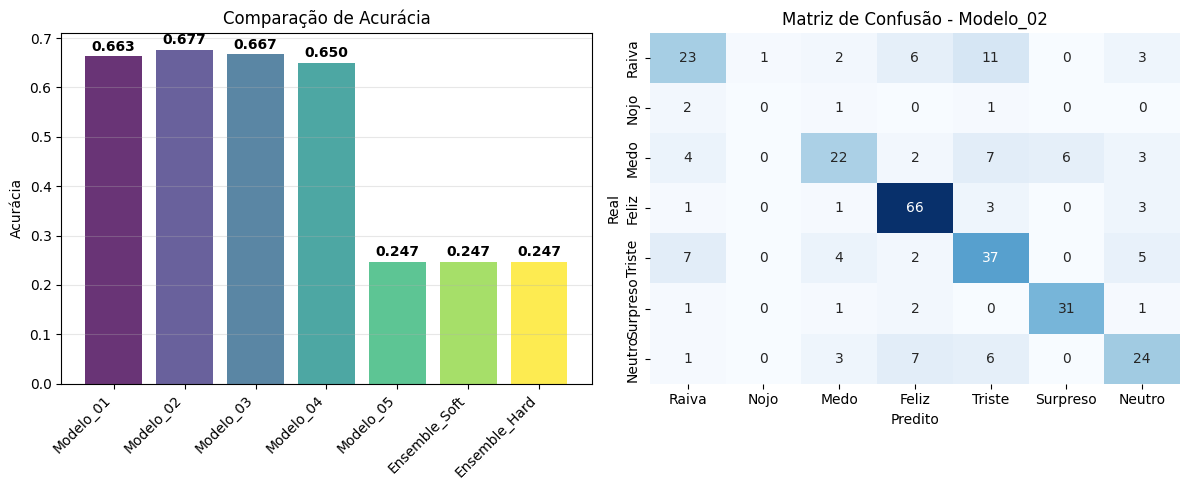

In [4]:
# Visualização simples dos resultados
plt.figure(figsize=(12, 5))

# Gráfico de barras com acurácias
plt.subplot(1, 2, 1)
nomes = list(resultados.keys())
accs = list(resultados.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(nomes)))

bars = plt.bar(nomes, accs, color=colors, alpha=0.8)
plt.title('Comparação de Acurácia')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, acc in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Matriz de confusão do melhor modelo
plt.subplot(1, 2, 2)
melhor_modelo = max(ensemble.models.items(), key=lambda x: resultados[x[0]])
modelo_nome, modelo = melhor_modelo

y_pred_melhor = modelo.predict(X_sample, verbose=0)
y_pred_melhor_cat = np.argmax(y_pred_melhor, axis=1)
cm = confusion_matrix(y_sample, y_pred_melhor_cat)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=EXPRESSOES, yticklabels=EXPRESSOES, cbar=False)
plt.title(f'Matriz de Confusão - {modelo_nome}')
plt.xlabel('Predito')
plt.ylabel('Real')

plt.tight_layout()
plt.show()

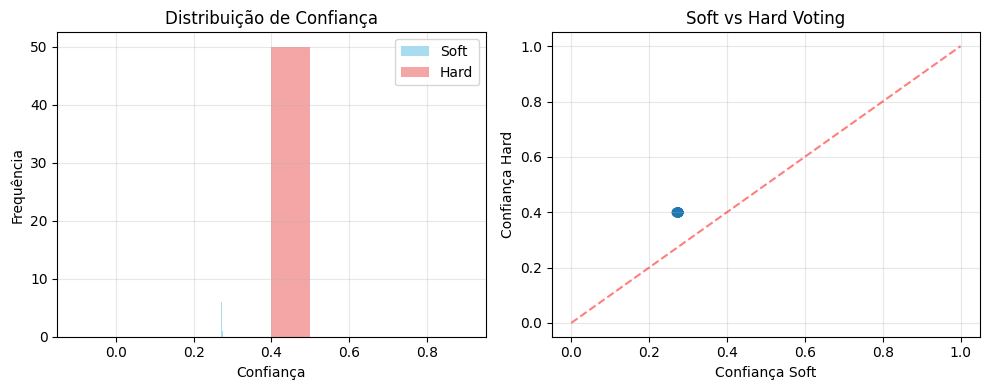

Confiança média - Soft: 0.273
Confiança média - Hard: 0.400
Casos de baixa confiança (<0.6) - Soft: 50
Casos de baixa confiança (<0.6) - Hard: 50


In [5]:
# Análise de confiança das predições
confiancas_soft = []
confiancas_hard = []

# Calcular confiança em amostra menor para demonstração
sample_conf = X_sample[:50]  # 50 imagens para análise rápida

for img in sample_conf:
    roi = ensemble.preprocessar(img.squeeze())
    soft = ensemble.ensemble_soft(roi)
    hard = ensemble.ensemble_hard(roi)
    
    confiancas_soft.append(soft['confianca'])
    confiancas_hard.append(hard['confianca'])

# Visualizar distribuição de confiança
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(confiancas_soft, bins=10, alpha=0.7, label='Soft', color='skyblue')
plt.hist(confiancas_hard, bins=10, alpha=0.7, label='Hard', color='lightcoral')
plt.xlabel('Confiança')
plt.ylabel('Frequência')
plt.title('Distribuição de Confiança')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(confiancas_soft, confiancas_hard, alpha=0.6)
plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)
plt.xlabel('Confiança Soft')
plt.ylabel('Confiança Hard')
plt.title('Soft vs Hard Voting')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Confiança média - Soft: {np.mean(confiancas_soft):.3f}")
print(f"Confiança média - Hard: {np.mean(confiancas_hard):.3f}")
print(f"Casos de baixa confiança (<0.6) - Soft: {sum(1 for c in confiancas_soft if c < 0.6)}")
print(f"Casos de baixa confiança (<0.6) - Hard: {sum(1 for c in confiancas_hard if c < 0.6)}")